In [40]:
!pip install mido pandas
!pip install pretty_midi
!pip install plotting
import pretty_midi
import numpy as np
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

In [41]:
%%capture
!wget http://hog.ee.columbia.edu/craffel/lmd/lmd_full.tar.gz
!tar -xvzf lmd_full.tar.gz
!ls lmd_full  # Adjust the path if necessary
!wget https://colinraffel.com/projects/lmd/match_scores.json

In [42]:
def compute_statistics(midi_file):
    """
    Given a path to a MIDI file, compute a dictionary of statistics about it

    Parameters
    ----------
    midi_file : str
        Path to a MIDI file.

    Returns
    -------
    statistics : dict
        Dictionary reporting the values for different events in the file.
    """
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)

        note_counts = [len(inst.notes) for inst in pm.instruments]
        pitch_ranges = [(min([note.pitch for note in inst.notes]),
                         max([note.pitch for note in inst.notes])) for inst in pm.instruments if inst.notes]
        avg_note_durations = [sum([note.end - note.start for note in inst.notes]) / len(inst.notes)
                              if inst.notes else 0 for inst in pm.instruments]
        avg_velocities = [sum([note.velocity for note in inst.notes]) / len(inst.notes)
                          if inst.notes else 0 for inst in pm.instruments]
        has_drums = any(inst.is_drum for inst in pm.instruments)

        melodic_intervals = []
        for inst in pm.instruments:
            if inst.notes:
                melodic_intervals += [abs(inst.notes[i + 1].pitch - inst.notes[i].pitch)
                                      for i in range(len(inst.notes) - 1)]
        avg_melodic_interval = sum(melodic_intervals) / len(melodic_intervals) if melodic_intervals else 0

        rhythmic_diversity = []
        for inst in pm.instruments:
            if inst.notes:
                rhythmic_diversity += [note.end - note.start for note in inst.notes]
        rhythmic_variability = (max(rhythmic_diversity) - min(rhythmic_diversity)
                                if rhythmic_diversity else 0)

        drum_patterns = []
        for inst in pm.instruments:
            if inst.is_drum and inst.notes:
                drum_patterns += [note.pitch for note in inst.notes]

        key_modulations = len(pm.key_signature_changes)


        return {
            'n_instruments': len(pm.instruments),     # Total number of instruments in the MIDI file
            'program_numbers': [i.program for i in pm.instruments if not i.is_drum],    # Program numbers for non-drum instruments, indicating their type (e.g., piano, guitar)
            'key_numbers': [k.key_number for k in pm.key_signature_changes], # Key numbers representing detected key signature changes
            # 'tempos': list(pm.get_tempo_changes()[1]), # List of tempos in the MIDI file (helps distinguish between slow and fast genres)
            # 'time_signature_changes': pm.time_signature_changes,  # List of time signature changes, if any (complex time signatures may indicate jazz/classical)
            'end_time': pm.get_end_time(), # Total duration of the piece in seconds
            # 'lyrics': [l.text for l in pm.lyrics], # Lyrics in the MIDI file, if available
            'note_counts': note_counts, # Number of notes played by each instrument
            # 'pitch_ranges': pitch_ranges, # Pitch range for each instrument as a tuple (lowest pitch, highest pitch)
            'avg_note_durations': avg_note_durations, # Average note durations for each instrument
            'avg_velocities': avg_velocities,  # Average velocities for each instrument
            'has_drums': has_drums,        # Whether the piece contains drums
            'drum_patterns': drum_patterns, # Extracted drum patterns, useful for analyzing rhythm sections
            'avg_melodic_interval': avg_melodic_interval, # Average melodic interval across all instruments
            'rhythmic_variability': rhythmic_variability, # Variability in note durations (useful for identifying rhythm complexity)
            'key_modulations': key_modulations, # Number of key modulations (changes in key signature)
            'tempo_estimate': pm.estimate_tempo() #numerical
        }
    except Exception as e:
        pass


In [43]:
!wget https://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MAGD-genreAssignment.cls

--2024-11-29 19:32:12--  https://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MAGD-genreAssignment.cls
Resolving www.ifs.tuwien.ac.at (www.ifs.tuwien.ac.at)... 128.131.167.11
Connecting to www.ifs.tuwien.ac.at (www.ifs.tuwien.ac.at)|128.131.167.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11625230 (11M) [text/plain]
Saving to: ‘msd-MAGD-genreAssignment.cls’

msd-MAGD-genreAssig 100%[===================>]  11.09M  3.48MB/s    in 3.2s    

2024-11-29 19:32:16 (3.48 MB/s) - ‘msd-MAGD-genreAssignment.cls’ saved [11625230/11625230]



In [44]:
def parse_genre_file(genre_file_path):
    genre_mapping = {}
    with open(genre_file_path, 'r') as f:
        for line in f:
            song_id, genre = line.strip().split('\t')
            genre_mapping[song_id] = genre
    return genre_mapping

# Load the genre mappings
genre_file_path = '/content/msd-MAGD-genreAssignment.cls'
genre_mapping = parse_genre_file(genre_file_path)


In [45]:
import json
import pandas as pd
import pretty_midi
with open('match_scores.json', 'r') as f:# open the file and make it a dictionary
    scores = json.load(f)

data_dict = []

for key in list(scores.keys())[:1000]: #loop through dictionary
    try:
      matches = scores[key]
      midi_md5 = list(matches.keys())[0] #Grabs the entire file name
      folder = midi_md5[0]  ##first char to find the folder
      file_path = f'lmd_full/{folder}/{midi_md5}.mid' #combine to get the file
      statistics = compute_statistics(file_path) #get stats of file

      song_id = key
      genre = genre_mapping.get(song_id, 'Unknown')
      statistics['genre'] = genre

      data_dict.append(statistics) # add it to a list
    except Exception as e:
      print(f'Error processing {key}: {e}')

# Create a DataFrame
df_dict = pd.DataFrame(data_dict) #create the df

df_dict = df_dict[df_dict['genre'] != 'Unknown']

# Save to CSV
df_dict.to_csv('dictionary_data.csv', index=False) #create a csv that can be used later
df_dict

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing TRSFMZE128F428883C: 'NoneType' object does not support item assignment
Error processing TRLNQGI128F92D5D37: 'NoneType' object does not support item assignment
Error processing TRWBOFQ128F145A8F1: 'NoneType' object does not support item assignment


,n_instruments,program_numbers,key_numbers,end_time,note_counts,avg_note_durations,avg_velocities,has_drums,drum_patterns,avg_melodic_interval,rhythmic_variability,key_modulations,tempo_estimate,genre
1,5,"[35, 0, 48, 0]",[],148.759375,"[249, 943, 592, 64, 349]","[0.44522464859437766, 0.1280222693531283, 0.77...","[77.56224899598394, 82.34358430540827, 72.4256...",True,"[37, 37, 37, 37, 37, 37, 49, 42, 35, 42, 37, 4...",4.687500,3.834375,0,206.401925,Pop_Rock
8,9,"[65, 33, 39, 1, 29, 45, 9, 61]",[],229.553484,"[412, 453, 609, 771, 743, 2413, 39, 394, 1604]","[0.2661218947208732, 0.27777445398730666, 0.11...","[115.37864077669903, 113.49668874172185, 114.0...",True,"[36, 49, 36, 36, 36, 36, 36, 36, 36, 36, 36, 3...",4.818145,73.545527,0,264.826538,Pop_Rock
15,12,"[50, 85, 46, 46, 46, 46, 119, 30, 80, 39, 81]",[],111.428460,"[24, 138, 93, 93, 93, 177, 1103, 8, 2, 80, 416...","[4.571424, 3.0807422608695596, 0.6728103870967...","[64.0, 64.0, 127.0, 127.0, 127.0, 127.0, 61.17...",True,"[36, 57, 36, 57, 36, 57, 40, 40, 40, 36, 57, 4...",3.502456,6.776779,0,280.000280,Electronic
16,11,"[1, 0, 25, 27, 56, 30, 32, 0, 67, 120]",[0],221.472194,"[1232, 832, 798, 103, 65, 10, 202, 1144, 244, ...","[0.6894867761363576, 0.7413417059495229, 0.650...","[87.34496753246754, 71.81850961538461, 70.5200...",True,"[82, 36, 42, 42, 82, 82, 38, 42, 33, 82, 42, 8...",8.409606,7.473687,1,180.135368,Pop_Rock
18,16,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",[],215.237880,"[429, 401, 562, 132, 140, 384, 12, 24, 774, 69...","[0.4708596875000002, 0.3095061822007481, 0.176...","[60.99300699300699, 60.69825436408978, 60.5854...",True,"[69, 39, 69, 69, 39, 69, 69, 39, 69, 39, 69, 3...",2.655373,30.664652,0,253.025605,Pop_Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,11,"[17, 50, 85, 53, 39, 80, 1, 48, 26, 84]",[],249.370117,"[5188, 2128, 655, 314, 276, 842, 44, 2462, 12,...","[0.1118463355941596, 0.16810825892857142, 1.65...","[87.09252120277564, 110.0, 119.10381679389313,...",True,"[42, 46, 42, 46, 39, 42, 42, 46, 42, 46, 39, 4...",10.531370,5.666504,0,249.801047,Pop_Rock
984,6,"[71, 1, 33, 26, 48]",[],130.624129,"[1812, 376, 983, 281, 162, 125]","[0.012937343635025732, 0.3393523548315605, 0.1...","[101.88741721854305, 110.42553191489361, 117.9...",True,"[37, 37, 37, 37, 37, 38, 38, 36, 38, 82, 49, 4...",13.838468,3.919031,0,263.765574,Pop_Rock
986,6,"[35, 0, 4, 25, 67, 69]",[0],154.500000,"[114, 550, 494, 458, 214, 214]","[1.1618352521929824, 0.16272727272727272, 1.19...","[70.00877192982456, 77.82181818181819, 52.2672...",False,[],5.631011,11.882812,1,160.000000,Vocal
989,17,"[25, 29, 30, 33, 54, 88, 99, 0, 48, 50, 100, 2...",[0],263.243788,"[1812, 144, 83, 83, 1020, 35, 353, 42, 338, 33...","[0.182526303288259, 0.9429302316406238, 1.5280...","[54.352097130242825, 59.979166666666664, 58.30...",True,"[42, 35, 42, 42, 38, 42, 35, 42, 35, 42, 35, 4...",4.798561,8.425301,1,189.988309,Pop_Rock


(array([  7.,  51., 101.,  84.,  39.,  41.,   6.,   3.,   1.,   1.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <BarContainer object of 10 artists>)

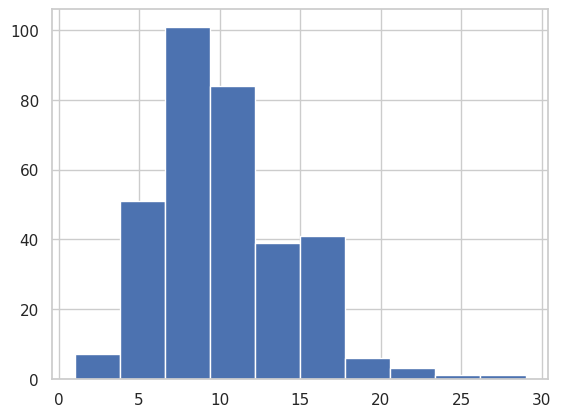

In [46]:
plt.hist(df_dict['n_instruments'])

The following graph shows the number of instruments for each song. X-axis demonstrating the number of instruments and Y-axis demonstrating the number of songs that have X number of instruments.

(array([ 6., 16., 35., 42., 39., 48., 56., 46., 31., 15.]),
 array([128.88887815, 144.30262079, 159.71636344, 175.13010608,
        190.54384873, 205.95759137, 221.37133402, 236.78507666,
        252.19881931, 267.61256195, 283.0263046 ]),
 <BarContainer object of 10 artists>)

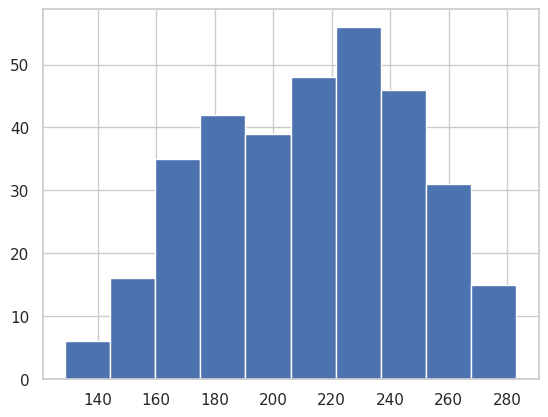

In [47]:
plt.hist(df_dict['tempo_estimate'])

The following graph shows the tempo estimate of each song. X-axis representing the tempo estimate of a song and Y-axis representing the number of songs that have X tempo estimate.

(array([[2., 0., 1., ..., 0., 0., 0.],
        [2., 0., 2., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 1.],
        ...,
        [2., 1., 1., ..., 0., 0., 0.],
        [2., 1., 5., ..., 2., 0., 0.],
        [1., 0., 2., ..., 0., 0., 0.]]),
 array([  0. ,  12.7,  25.4,  38.1,  50.8,  63.5,  76.2,  88.9, 101.6,
        114.3, 127. ]),
 <a list of 334 BarContainer objects>)

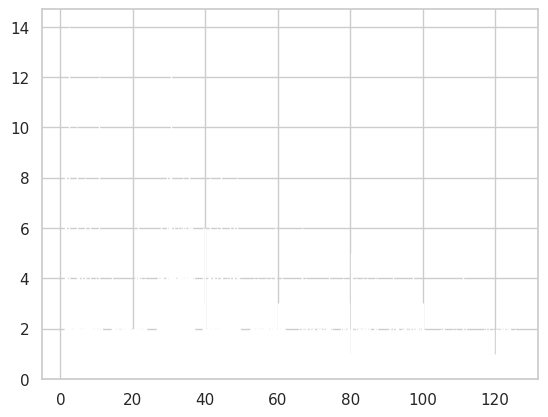

In [48]:
plt.hist(df_dict['program_numbers'])

In [49]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pandas as pd
import numpy as np

# Load the data
df_dict = pd.read_csv('dictionary_data.csv')

# Separate numeric and non-numeric data
numeric_cols = df_dict.select_dtypes(include=np.number).columns
non_numeric_cols = df_dict.select_dtypes(exclude=np.number).columns

# Handle numeric columns
numeric_imputer = SimpleImputer(strategy='most_frequent')
df_numeric = pd.DataFrame(
    numeric_imputer.fit_transform(df_dict[numeric_cols]),
    columns=numeric_cols
)

# Handle non-numeric columns
df_non_numeric = df_dict[non_numeric_cols].copy()

# Process specific non-numeric columns if needed
#for col in non_numeric_cols:
#    df_non_numeric[col] = df_non_numeric[col].apply(
#        lambda x: np.mean(eval(x)) if pd.notnull(x) and isinstance(x, str) and x.startswith("[") else np.nan
#   )

# Impute non-numeric columns
non_numeric_imputer = SimpleImputer(strategy='most_frequent')
df_non_numeric = pd.DataFrame(
    non_numeric_imputer.fit_transform(df_non_numeric),
    columns=non_numeric_cols
)

# Combine numeric and processed non-numeric columns
df_processed = pd.concat([df_numeric, df_non_numeric], axis=1)

# Scale numeric data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)

# Feature expansion
poly = PolynomialFeatures(degree=2, include_bias=False)
expanded_features = poly.fit_transform(scaled_features)

# Convert back to DataFrame for expanded features
expanded_df = pd.DataFrame(expanded_features, columns=poly.get_feature_names_out(numeric_cols))

print(f"Preprocessed and expanded features: {expanded_df.shape}")
expanded_df['genre'] = df_dict['genre']
expanded_df

Preprocessed and expanded features: (334, 27)


,n_instruments,end_time,avg_melodic_interval,rhythmic_variability,key_modulations,tempo_estimate,n_instruments^2,n_instruments end_time,n_instruments avg_melodic_interval,n_instruments rhythmic_variability,...,avg_melodic_interval rhythmic_variability,avg_melodic_interval key_modulations,avg_melodic_interval tempo_estimate,rhythmic_variability^2,rhythmic_variability key_modulations,rhythmic_variability tempo_estimate,key_modulations^2,key_modulations tempo_estimate,tempo_estimate^2,genre
0,-1.278641,-0.852530,-0.614329,-0.570833,-0.717248,-0.180328,1.634923,1.090080,0.785507,0.729890,...,0.350680,0.440627,0.110781,0.325850,0.409429,0.102937,0.514445,0.129340,0.032518,Pop_Rock
1,-0.300254,0.032210,-0.570903,6.635400,-0.717248,1.511392,0.090152,-0.009671,0.171416,-1.992303,...,-3.788172,0.409479,-0.862859,44.028539,-4.759229,10.028689,0.514445,-1.084043,2.284305,Pop_Rock
2,0.433537,-1.261324,-1.008236,-0.266669,-0.717248,1.950757,0.187954,-0.546830,-0.437107,-0.115611,...,0.268865,0.723155,-1.966822,0.071112,0.191268,-0.520206,0.514445,-1.399176,3.805451,Electronic
3,0.188940,-0.056285,0.622891,-0.194627,0.428976,-0.940892,0.035698,-0.010634,0.117689,-0.036773,...,-0.121232,0.267206,-0.586074,0.037880,-0.083490,0.183123,0.184021,-0.403620,0.885279,Pop_Rock
4,1.411924,-0.124554,-1.289805,2.202687,-0.717248,1.169689,1.993530,-0.175861,-1.821107,3.110026,...,-2.841035,0.925110,-1.508670,4.851828,-1.579873,2.576457,0.514445,-0.838957,1.368171,Pop_Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0.188940,0.249213,1.328161,-0.381441,-0.717248,1.076319,0.035698,0.047086,0.250943,-0.072069,...,-0.506615,-0.952621,1.429526,0.145497,0.273588,-0.410552,0.514445,-0.771988,1.158464,Pop_Rock
330,-1.034044,-1.051121,2.427434,-0.562082,-0.717248,1.480671,1.069247,1.086905,-2.510074,0.581217,...,-1.364417,-1.741073,3.594231,0.315936,0.403152,-0.832258,0.514445,-1.062008,2.192386,Pop_Rock
331,-1.034044,-0.789667,-0.300708,0.261156,0.428976,-1.523924,1.069247,0.816550,0.310946,-0.270047,...,-0.078532,-0.128997,0.458257,0.068203,0.112030,-0.397982,0.184021,-0.653727,2.322345,Vocal
332,1.656521,0.401137,-0.577413,-0.096256,0.428976,-0.655595,2.744062,0.664492,-0.956497,-0.159451,...,0.055580,-0.247696,0.378549,0.009265,-0.041292,0.063105,0.184021,-0.281234,0.429804,Pop_Rock


In [50]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Scale the features (exclude 'genre' column from scaling)
# scaler = MinMaxScaler()
# df_norm = pd.DataFrame(scaler.fit_transform(expanded_df.drop(columns='genre')), columns=expanded_df.drop(columns='genre').columns)
df_norm = expanded_df.drop(columns='genre')

# Encode the 'genre' column (target) using LabelEncoder
label_encoder = LabelEncoder()
expanded_df['genre_encoded'] = label_encoder.fit_transform(expanded_df['genre'])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_norm, expanded_df['genre_encoded'], test_size=0.20, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")


# Train a linear SVM
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

train_pred_linear = svm_linear.predict(X_train)
test_pred_linear = svm_linear.predict(X_test)

print('Linear SVM Classification Report:')
print(classification_report(y_test, test_pred_linear))

# Train an RBF SVM
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)
train_pred_rbf = svm_linear.predict(X_train)
test_pred_rbf = svm_rbf.predict(X_test)

print('RBF SVM Classification Report:')
print(classification_report(y_test, test_pred_rbf))

Training data shape: (267, 27)
Testing data shape: (67, 27)
Training labels shape: (267,)
Testing labels shape: (67,)
Linear SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         2
          13       0.63      0.81      0.71        42
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         3
          18       0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [51]:
# Evaluate the model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score

train_accuracy = mse(y_train, train_pred_linear)
test_accuracy = mse(y_test, test_pred_linear)
train_accuracy_acc = accuracy_score(y_train, train_pred_linear)
test_accuracy_acc = accuracy_score(y_test, test_pred_linear)

print(f"Training Accuracy Linear MSE: {train_accuracy:.2f}")
print(f"Testing Accuracy Linear MSE: {test_accuracy:.2f}")
print(f"Training Accuracy Linear ACC: {train_accuracy_acc:.2f}")
print(f"Testing Accuracy Linear ACC: {test_accuracy_acc:.2f}")

train_accuracy_rbf = mse(y_train, train_pred_rbf)
test_accuracy_rbf = mse(y_test, test_pred_rbf)
train_accuracy_rbf_acc = accuracy_score(y_train, train_pred_rbf)
test_accuracy_rbf_acc = accuracy_score(y_test, test_pred_rbf)

print(f"Training Accuracy RBF MSE: {train_accuracy_rbf:.2f}")
print(f"Testing Accuracy RBF MSE: {test_accuracy_rbf:.2f}")
print(f"Training Accuracy RBF ACC: {train_accuracy_rbf_acc:.2f}")
print(f"Testing Accuracy RBF ACC: {test_accuracy_rbf_acc:.2f}")


Training Accuracy Linear MSE: 13.48
Testing Accuracy Linear MSE: 21.03
Training Accuracy Linear ACC: 0.69
Testing Accuracy Linear ACC: 0.52
Training Accuracy RBF MSE: 13.48
Testing Accuracy RBF MSE: 14.19
Training Accuracy RBF ACC: 0.69
Testing Accuracy RBF ACC: 0.63


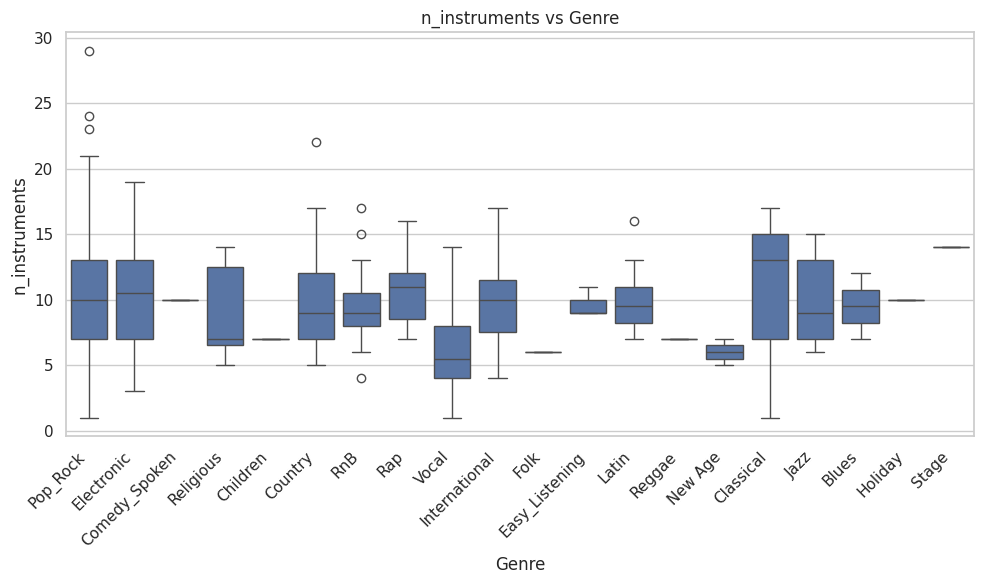

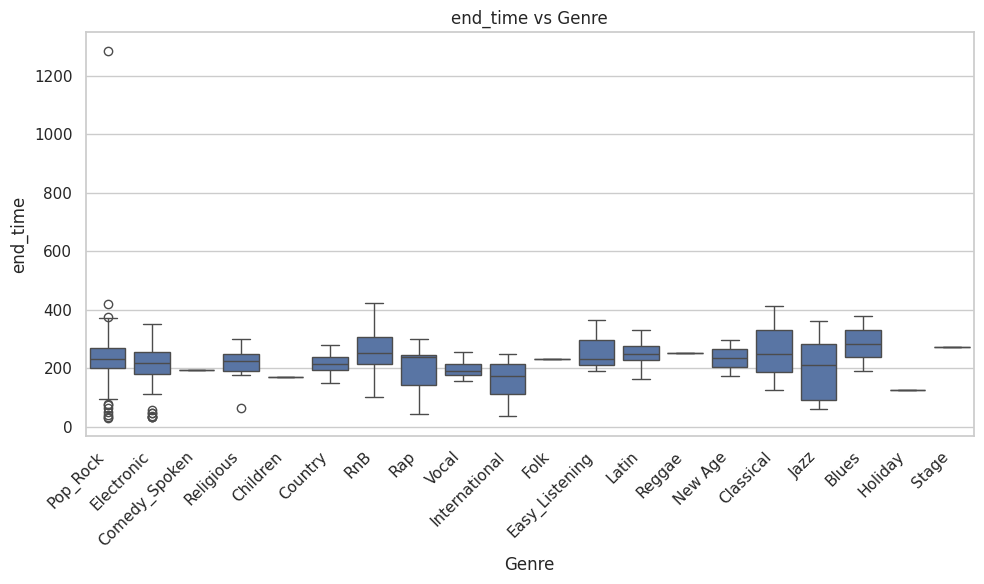

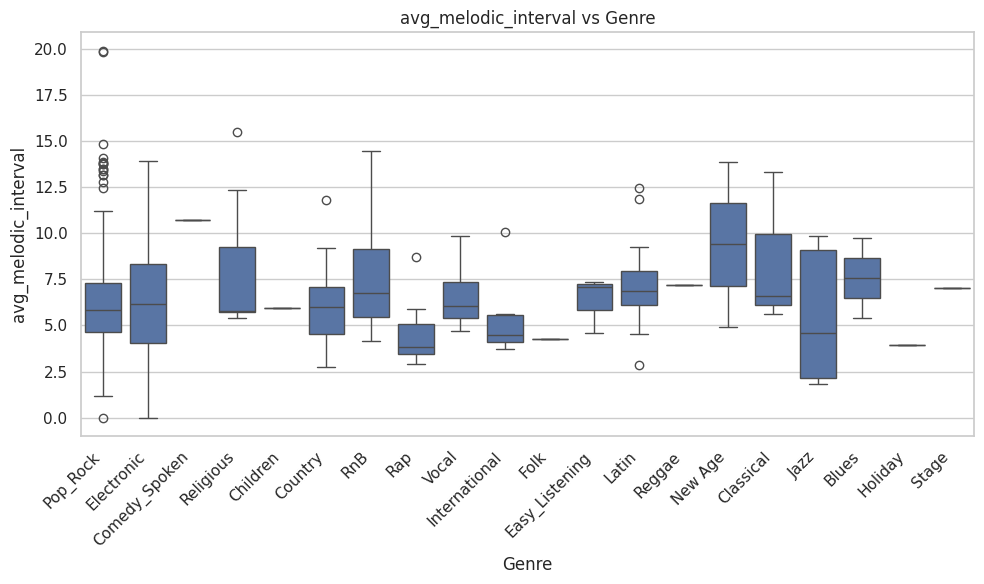

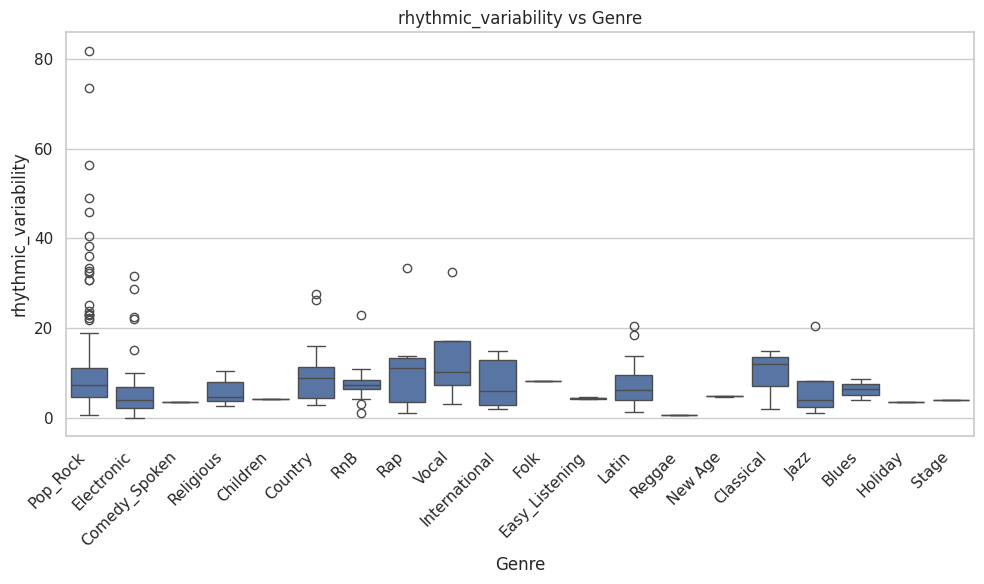

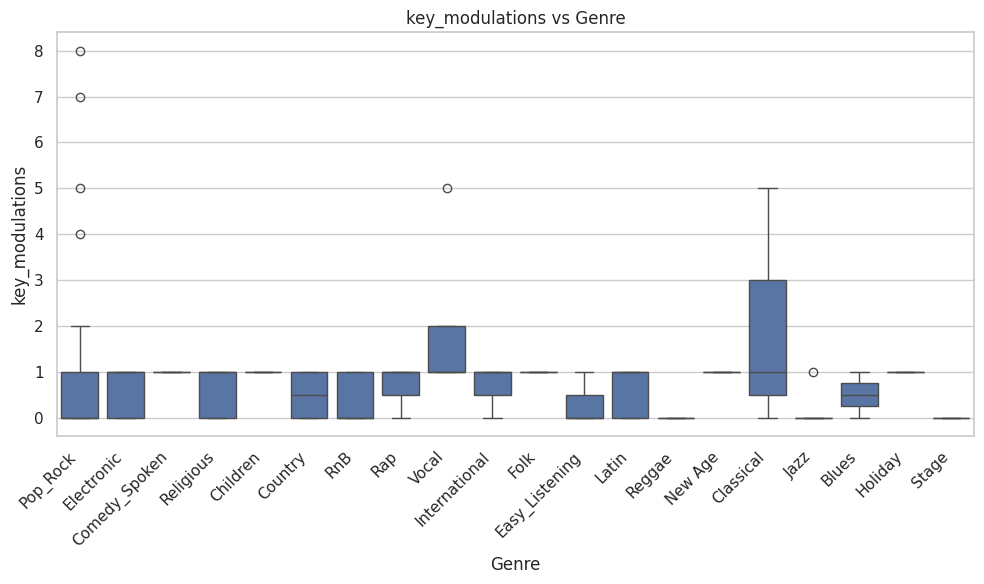

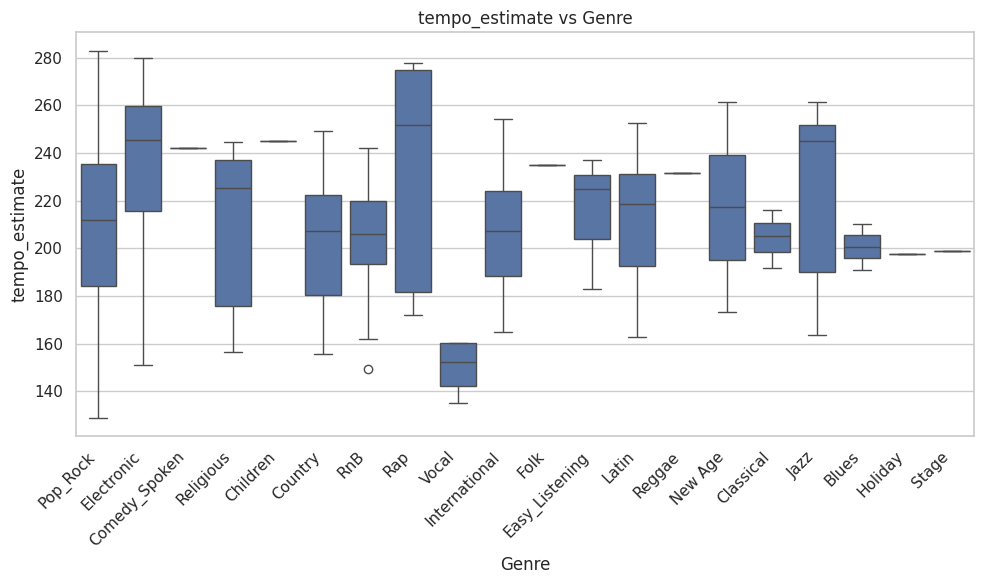

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")

# Prepare a list of numeric features (exclude genre and non-numeric columns)
numeric_features = df_dict.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'genre_encoded']

# Create box plots for each numeric feature against genre
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='genre', y=feature, data=df_dict)
    plt.xticks(rotation=45, ha='right')  # Rotate genre labels for readability
    plt.title(f'{feature} vs Genre')
    plt.ylabel(feature)
    plt.xlabel('Genre')
    plt.tight_layout()
    plt.show()


The following box plots demonstrate each song genre vs song features represented as number of instruments, end time, average melodic interval, rhythmic variability, and key modulations. By analyzing these graphs we are able to determine the key differences of features between each genre. Understanding and pointing out the difference in features between song genres is important because this helps our model learn and understand the indications and trends associated to each genre for prediction.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


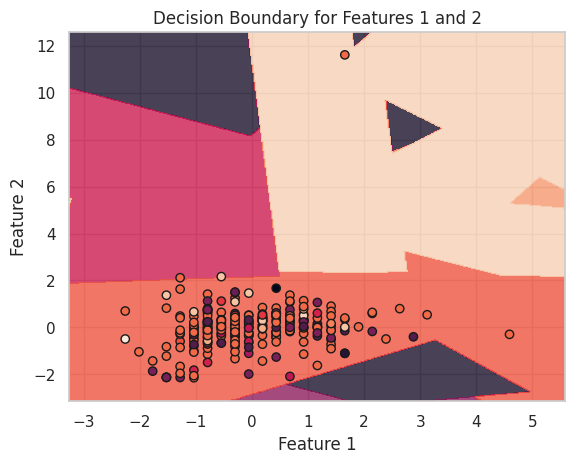

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


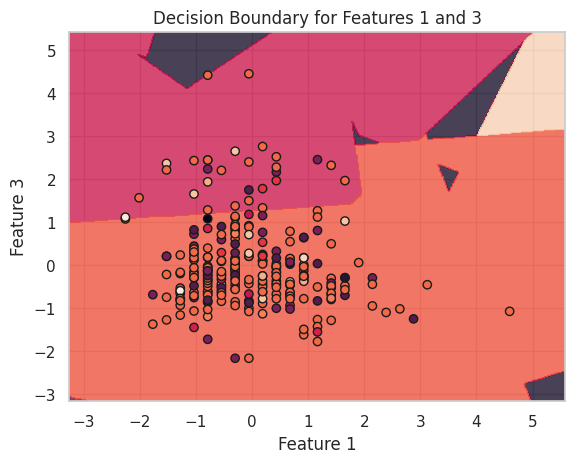

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


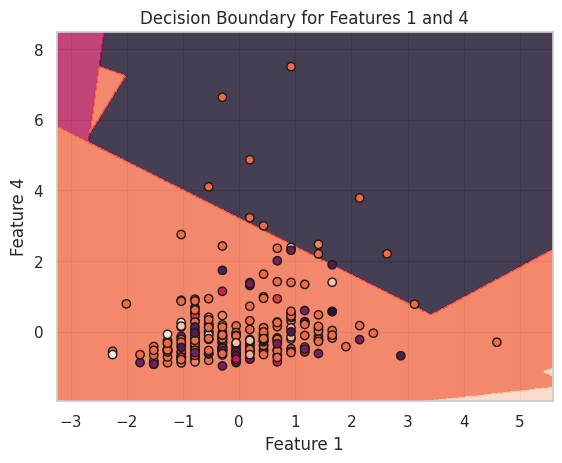

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


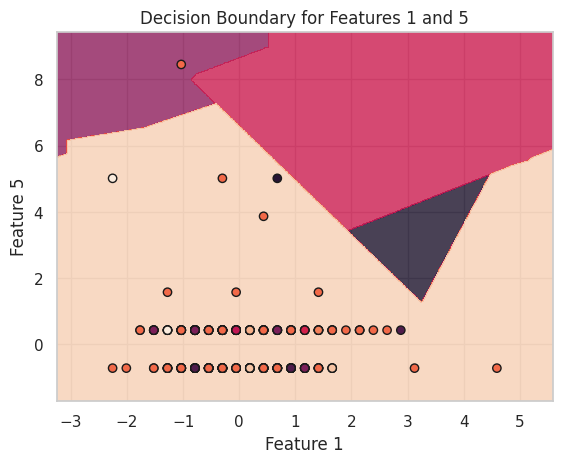

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


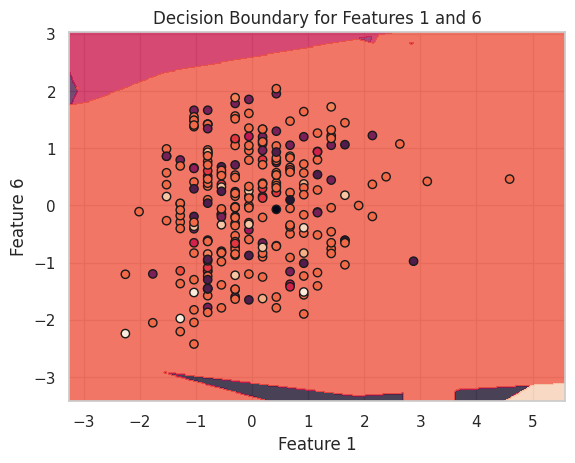

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from itertools import combinations
from sklearn.metrics import accuracy_score

def plot_decision_boundary(X, y, model, feature_pair, title):

    h = .02  # Step size in the mesh
    f1, f2 = feature_pair  # Unpack feature indices
    X_np = X.to_numpy() # Ensure NumPy array
    X_selected = X_np[:, [f1, f2]]

    x_min, x_max = X_selected[:, 0].min() - 1, X_selected[:, 0].max() + 1
    y_min, y_max = X_selected[:, 1].min() - 1, X_selected[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Ensure tuple of 2 features
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_full_features = np.zeros((grid_points.shape[0], X_np.shape[1]))
    grid_full_features[:, [f1, f2]] = grid_points

    Z = model.predict(grid_full_features)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_selected[:, 0], X_selected[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel(f'Feature {f1 + 1}')
    plt.ylabel(f'Feature {f2 + 1}')
    plt.title(title)
    plt.show()

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Select feature pairs to visualize
feature_combinations = list(combinations(range(X_train.shape[1]), 2))
subset_combinations = feature_combinations[:5]  # Limit to first 5 pairs for visualization

# Plot decision boundaries for selected feature pairs
for feature_pair in subset_combinations:
    plot_decision_boundary(
        X_train,
        y_train,
        svm_model,
        feature_pair,
        title=f'Decision Boundary for Features {feature_pair[0] + 1} and {feature_pair[1] + 1}'
    )
